In [58]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

In [59]:
df = pd.read_csv('data.csv')
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,16-Dec-2016,8178.20,8178.70,8127.45,8139.45,209268331,9854.07
1,19-Dec-2016,8126.00,8132.50,8094.85,8104.35,110669713,5272.20
2,20-Dec-2016,8110.60,8124.10,8062.75,8082.40,132026742,6296.67
3,21-Dec-2016,8105.85,8112.55,8053.25,8061.30,127543733,6304.60
4,22-Dec-2016,8043.85,8046.45,7964.95,7979.10,126409580,6206.58


In [60]:
df.shape

(250, 7)

In [61]:
df = df.drop(['Shares Traded','Turnover (Rs. Cr)'], axis =1)

In [62]:
df = df.drop(['Date'], axis=1)
df.head()

,Open,High,Low,Close
0,8178.20,8178.70,8127.45,8139.45
1,8126.00,8132.50,8094.85,8104.35
2,8110.60,8124.10,8062.75,8082.40
3,8105.85,8112.55,8053.25,8061.30
4,8043.85,8046.45,7964.95,7979.10


In [63]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [64]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [65]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.5))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [66]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (206, 20, 4)
y_train (206,)
X_test (23, 20, 4)
y_test (23,)


In [67]:
model = build_model([X_train.shape[2], window, 100, 1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 4), return_sequences=True, units=20)`
  


Compilation Time :  0.01689434051513672


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [68]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=300,
    validation_split=0.1,
    verbose=2)

/usr/local/lib/python3.5/dist-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 185 samples, validate on 21 samples
Epoch 1/300
0s - loss: 0.8939 - acc: 0.0000e+00 - val_loss: 2.5244 - val_acc: 0.0000e+00
Epoch 2/300
0s - loss: 0.4653 - acc: 0.0000e+00 - val_loss: 1.8870 - val_acc: 0.0000e+00
Epoch 3/300
0s - loss: 0.2723 - acc: 0.0000e+00 - val_loss: 1.3422 - val_acc: 0.0000e+00
Epoch 4/300
0s - loss: 0.1455 - acc: 0.0000e+00 - val_loss: 0.8694 - val_acc: 0.0000e+00
Epoch 5/300
0s - loss: 0.0998 - acc: 0.0000e+00 - val_loss: 0.5874 - val_acc: 0.0000e+00
Epoch 6/300
0s - loss: 0.0813 - acc: 0.0000e+00 - val_loss: 0.4401 - val_acc: 0.0000e+00
Epoch 7/300
0s - loss: 0.0953 - acc: 0.0000e+00 - val_loss: 0.4396 - val_acc: 0.0000e+00
Epoch 8/300
0s - loss: 0.0903 - acc: 0.0000e+00 - val_loss: 0.4326 - val_acc: 0.0000e+00
Epoch 9/300
0s - loss: 0.1060 - acc: 0.0000e+00 - val_loss: 0.4740 - val_acc: 0.0000e+00
Epoch 10/300
0s - loss: 0.0868 - acc: 0.0000e+00 - val_loss: 0.3739 - val_acc: 0.0000e+00
Epoch 11/300
0s - loss: 0.0751 - acc: 0.0000e+00 - val_loss: 0.3

0s - loss: 0.0492 - acc: 0.0000e+00 - val_loss: 0.0856 - val_acc: 0.0000e+00
Epoch 94/300
0s - loss: 0.0512 - acc: 0.0000e+00 - val_loss: 0.4151 - val_acc: 0.0000e+00
Epoch 95/300
0s - loss: 0.0606 - acc: 0.0000e+00 - val_loss: 0.1186 - val_acc: 0.0000e+00
Epoch 96/300
0s - loss: 0.0477 - acc: 0.0000e+00 - val_loss: 0.2668 - val_acc: 0.0000e+00
Epoch 97/300
0s - loss: 0.0467 - acc: 0.0000e+00 - val_loss: 0.1245 - val_acc: 0.0000e+00
Epoch 98/300
0s - loss: 0.0496 - acc: 0.0000e+00 - val_loss: 0.2457 - val_acc: 0.0000e+00
Epoch 99/300
0s - loss: 0.0443 - acc: 0.0000e+00 - val_loss: 0.1622 - val_acc: 0.0000e+00
Epoch 100/300
0s - loss: 0.0418 - acc: 0.0000e+00 - val_loss: 0.1416 - val_acc: 0.0000e+00
Epoch 101/300
0s - loss: 0.0454 - acc: 0.0000e+00 - val_loss: 0.2589 - val_acc: 0.0000e+00
Epoch 102/300
0s - loss: 0.0474 - acc: 0.0000e+00 - val_loss: 0.1139 - val_acc: 0.0000e+00
Epoch 103/300
0s - loss: 0.0586 - acc: 0.0000e+00 - val_loss: 0.2727 - val_acc: 0.0000e+00
Epoch 104/300
0s - 

0s - loss: 0.0393 - acc: 0.0000e+00 - val_loss: 0.3130 - val_acc: 0.0000e+00
Epoch 186/300
0s - loss: 0.0403 - acc: 0.0000e+00 - val_loss: 0.1392 - val_acc: 0.0000e+00
Epoch 187/300
0s - loss: 0.0315 - acc: 0.0000e+00 - val_loss: 0.1385 - val_acc: 0.0000e+00
Epoch 188/300
0s - loss: 0.0370 - acc: 0.0000e+00 - val_loss: 0.1723 - val_acc: 0.0000e+00
Epoch 189/300
0s - loss: 0.0375 - acc: 0.0000e+00 - val_loss: 0.1175 - val_acc: 0.0000e+00
Epoch 190/300
0s - loss: 0.0374 - acc: 0.0000e+00 - val_loss: 0.2367 - val_acc: 0.0000e+00
Epoch 191/300
0s - loss: 0.0355 - acc: 0.0000e+00 - val_loss: 0.0967 - val_acc: 0.0000e+00
Epoch 192/300
0s - loss: 0.0363 - acc: 0.0000e+00 - val_loss: 0.2745 - val_acc: 0.0000e+00
Epoch 193/300
0s - loss: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0844 - val_acc: 0.0000e+00
Epoch 194/300
0s - loss: 0.0344 - acc: 0.0000e+00 - val_loss: 0.2082 - val_acc: 0.0000e+00
Epoch 195/300
0s - loss: 0.0396 - acc: 0.0000e+00 - val_loss: 0.1257 - val_acc: 0.0000e+00
Epoch 196/300

0s - loss: 0.0359 - acc: 0.0000e+00 - val_loss: 0.1948 - val_acc: 0.0000e+00
Epoch 278/300
0s - loss: 0.0348 - acc: 0.0000e+00 - val_loss: 0.0784 - val_acc: 0.0000e+00
Epoch 279/300
0s - loss: 0.0317 - acc: 0.0000e+00 - val_loss: 0.1672 - val_acc: 0.0000e+00
Epoch 280/300
0s - loss: 0.0309 - acc: 0.0000e+00 - val_loss: 0.1299 - val_acc: 0.0000e+00
Epoch 281/300
0s - loss: 0.0281 - acc: 0.0000e+00 - val_loss: 0.1315 - val_acc: 0.0000e+00
Epoch 282/300
0s - loss: 0.0337 - acc: 0.0000e+00 - val_loss: 0.1019 - val_acc: 0.0000e+00
Epoch 283/300
0s - loss: 0.0271 - acc: 0.0000e+00 - val_loss: 0.0674 - val_acc: 0.0000e+00
Epoch 284/300
0s - loss: 0.0341 - acc: 0.0000e+00 - val_loss: 0.2867 - val_acc: 0.0000e+00
Epoch 285/300
0s - loss: 0.0414 - acc: 0.0000e+00 - val_loss: 0.0768 - val_acc: 0.0000e+00
Epoch 286/300
0s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.3029 - val_acc: 0.0000e+00
Epoch 287/300
0s - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.0999 - val_acc: 0.0000e+00
Epoch 288/300

In [69]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.03 MSE (0.16 RMSE)
Test Score: 0.99 MSE (0.99 RMSE)


In [70]:
diff = []
ratio = []
pred = model.predict(X_train)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

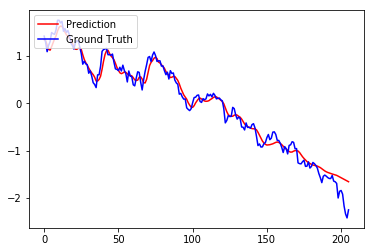

In [71]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_train, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()